# Product Matching

Matching a query product image against a set of reference product images and finding the reference products that are most similar to the query product.

![](../MISC/matching_header.PNG)

In [1]:
import sys
sys.path.append("../python_code")
from AttrPredModel import AttrPred_Resnet50
from iMatDataset import iMatDataset
import matplotlib.pyplot as plt
import torch
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from PIL import Image

### loading reference dataset

In [2]:
json_path =  "/home/mprinzler/storage/iMaterialist/validation.json"  # must be changed according to your file structure!
image_path = "/home/mprinzler/storage/iMaterialist/validation"  # must be changed according to your file structure!
attr_descr_path = "/home/mprinzler/storage/iMaterialist/iMat_fashion_2018_label_map_228.csv"  # must be changed according to your file structure!

ds = iMatDataset(labels_file=json_path, img_dir=image_path, attr_descr_file=attr_descr_path,
                rgb_mean=[0.6765, 0.6347, 0.6207], rgb_std=[0.3284, 0.3371, 0.3379])

### loading model

In [3]:
# path to downloaded model file. Must be adapted to fit your file structure!
model_path = "../TrainedModels/epoch=03-avg_f1_score=0.54.ckpt"
model = AttrPred_Resnet50.load_from_checkpoint(model_path).cuda()
model.eval()
print("Model Loaded successfully")

Model Loaded successfully


### analyzing reference product images
the execution of the following cell is not necessary if the attribute scores of the reference set have been calculated already. Calculating these scores requires to run an inference on the whole reference dataset and therefore can be time consuming. For this reason, this repository provides the precalculated attribute scores for the iMaterialist Fashion Validation set. These scores are stored in the `ref_attr_scores.pth` file.


In [5]:
# calculate attribute scores for reference images  -> NOT NECESSARY IF "ref_attr_scores.pth" exists
dataloader = DataLoader(ds, batch_size=100)
ref_attr_scores = []
with torch.no_grad():
    for batch in tqdm(iterable=dataloader):
        img_tensors, _ = batch
        img_tensors = img_tensors.cuda()
        ref_attr_scores.append(model(img_tensors).cpu())
        del img_tensors
ref_attr_scores = torch.cat(ref_attr_scores, dim=0)

# saving reference attribute scores so that don't have to be recalculated everytime
torch.save(ref_attr_scores, "ref_attr_scores.pth")

100%|██████████| 99/99 [07:03<00:00,  4.28s/it]


In [34]:
# loading previously saved ref_attr_scores (if existing)
ref_attr_scores = torch.load("ref_attr_scores.pth")

### retreive attribute scores for query images

Query product


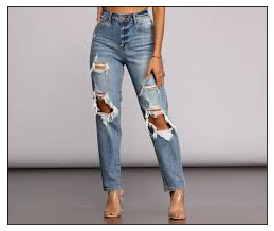

In [6]:
# load query image
query_img_path = "../MISC/matching_examples/jeans.jpg"
query_img_pil = Image.open(query_img_path).convert("RGB")
print("Query product")
plt.imshow(query_img_pil)
plt.gca().tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.show()

In [8]:
# retreive similar products
pred_attr_scores = model(ds.trafo_pil2tensor(query_img_pil).unsqueeze(0).cuda())[0].cpu()

### find reference products with most similar attribute scores

Similar reference Products:


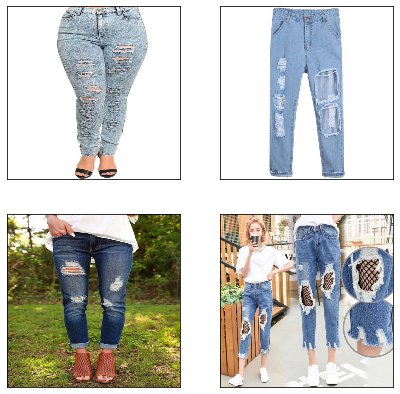

<Figure size 432x288 with 0 Axes>

In [9]:
ref_attr_score_distances = torch.sum((pred_attr_scores - ref_attr_scores)**2, dim=1).sqrt()
closest_4 = torch.argsort(ref_attr_score_distances)[:4].tolist()

print("Similar reference Products:")
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7,7))
for i, ref_idx in enumerate(closest_4):
    img_tensor, _ = ds[ref_idx]
    img_pil = ds.trafo_tensor2pil(img_tensor)
    axes.flatten()[i].imshow(img_pil)
    axes.flatten()[i].tick_params(left=False, bottom=False, labelleft=False, labelbottom=False)
plt.savefig("../MISC/matches.png")
plt.show()
plt.tight_layout()